# Advanced Lane Finding Project

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Camera Calibration

In the below cell we perform camera calibration using the given calibration checkerboard patterns and save the undistorted output

In [2]:
def camera_calibration(calibration_images, nx, ny):
    objpoints = []
    imgpoints = []
    # Prepare objects points (0, 0, 0), (1, 0, 0), (2, 0, 0) .. (7, 5, 0)
    objp = np.zeros((9*6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    for img_path in calibration_images:
        img_name = img_path.split('\\')[2]
        img = mpimg.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)               
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)        
        if ret == True:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.axis('off')
            plt.imshow(img)
            mpimg.imsave('.\\output_images\\marked_{}'.format(img_name), img)
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

Calculating Camera Calibration Matrix
Done


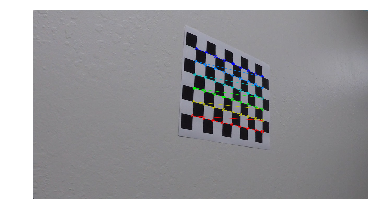

In [3]:
print('Calculating Camera Calibration Matrix')
calibration_images = glob.glob('.\\camera_cal\\calibration*.jpg')
mtx, dist = camera_calibration(calibration_images, 9, 6)
for img_path in calibration_images:
    img_name = img_path.split('\\')[2]
    img = mpimg.imread(img_path)    
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    mpimg.imsave('.\\output_images\\undistorted_{}'.format(img_name), undist)
print('Done')

## Thresholding

We apply color transforms and gradients to create a thresholded binary image

In [4]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel_abs/np.max(sobel_abs))
    binary_output = np.zeros_like(sobel_scaled)
    binary_output[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    sobel = np.uint8(255 * sobel_mag/np.max(sobel_mag))
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    gradient_direction = np.arctan2(sobely_abs, sobelx_abs)
    binary_output = np.zeros_like(gradient_direction)
    binary_output[(gradient_direction >= thresh[0]) & (gradient_direction <= thresh[1])] = 1
    return binary_output

def hsv_select(img, thresh=(0, 255)):
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_light = cv2.inRange(image_hsv, np.array([0, 0, 220]), np.array([255, 255, 255]))
    return cv2.bitwise_and(img, img, mask=mask_light)

def threshold(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    #gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 200))
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.3, 0.5))
    #combined = np.zeros_like(color_select)
    #combined[(color_select == 255)] = 1
    color_select = hsv_select(img, (100, 255))
    grayscale_selected = cv2.cvtColor(color_select, cv2.COLOR_RGB2GRAY)
    return grayscale_selected

## Lane Detection Pipeline

To detect lane pixels and fit to find the lane boundary we follow the below steps -

1. Apply thresholding to retain the lane lines
2. Use perspective transform to warp the frame
3. Find pixel centroids for left and right lane lines
4. Fit a line passing through the centroids found for left and right lane line pixels
5. Find curvature
6. Draw overlay on the original frame

In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #polynomial coefficients for the last n fits
        self.last_n_fits = []
        #polynomial coefficients for the most recent fit
        self.current_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

class LaneFinder():
    def __init__(self):
        self.LeftLine = Line()
        self.RightLine = Line()
        # window settings
        # Choose the number of sliding windows
        self.nwindows = 12
        self.window_width = 50 
        # Break image into 12 vertical layers since image height is 720
        self.window_height = 720 // self.nwindows
        # How much to slide left and right for searching
        self.margin = 100
        # frame count
        self.frame_count = 0
        self.M = None
        self.Minv = None

    '''
    Given from and to vertices, return both Camera Matrix (M) and (M Inverse)
    '''
    def get_camera_matrix(self, from_vertices, to_vertices):
        #roi = region_of_interest(undist, vertices)
        src = np.float32(from_vertices)
        dst = np.float32(to_vertices)
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        return M, Minv
        #img = cv2.polylines(img, [vertices], True, (0, 255, 0))
        #return cv2.polylines(img, [rect_vertices], True, (255, 0, 0))
    
    '''
    Warp image
    '''
    def warp(self, img, camera_matrix):
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, camera_matrix, img_size, flags=cv2.INTER_LINEAR)
        warped = 255.0 * warped
        return warped

    def window_mask(self, width, height, img_ref, center, level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
               max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    '''
    Using histogram, find the lane pixel centroids
    '''
    def find_window_centroids(self, warped):    
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(self.window_width) # Create our window template that we will use for convolutions        
        
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
    
        # Sum quarter bottom of image to get slice, could use a different ratio
        if not self.LeftLine.detected:
            l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
            l_center = np.argmax(np.convolve(window,l_sum))-self.window_width/2
        else:
            l_center = self.LeftLine.bestx

        if not self.RightLine.detected:
            r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
            r_center = np.argmax(np.convolve(window,r_sum))-self.window_width/2+int(warped.shape[1]/2)
        else:
            r_center = self.RightLine.bestx
    
        if(not l_center or not r_center):
            print('Center points not found in frame {}'.format(self.frame_count))
            return []

        # Add what we found for the first layer
        #window_centroids.append((l_center,r_center))        
        
        # Go through each layer looking for max pixel locations
        for level in range(0,(int)(warped.shape[0]/self.window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*self.window_height):
                                        int(warped.shape[0]-level*self.window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, 
            # not center of window
            offset = self.window_width/2
            prev_diff = (r_center - l_center)

            l_min_index = int(max(l_center+offset-self.margin, 0))
            l_max_index = int(min(l_center+offset+self.margin, warped.shape[1]//2))
            
            l_convolved = np.argmax(conv_signal[l_min_index:l_max_index])        
            
            # Find the best right centroid by using past right center as a reference        
            r_min_index = int(max(r_center+offset-self.margin, warped.shape[1]//2))
            r_max_index = int(min(r_center+offset+self.margin, warped.shape[1]))
            r_convolved = np.argmax(conv_signal[r_min_index:r_max_index])
            
            # If no pixels are detected within the window, try to 
            # approximate the location using previous diff
            if(l_convolved == 0):
                l_center = r_center - prev_diff
            else:            
                l_center = l_convolved + l_min_index - offset/2
        
            if(r_convolved == 0):
                r_center = l_center + prev_diff
            else:
                r_center = r_convolved + r_min_index - offset/2
        
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
        
        return window_centroids

    '''
    Given the Left or Right (X,Y) co-ordinates for pixels 
    found in the warped image, fit a line to these and 
    return the X Co-Ordinates for fitted line
    '''
    def fit_line_coeff(self, x, y):
        fit_coeff = np.polyfit(y, x, 2)
        return fit_coeff        
    
    '''
    Draw overlay green lane patch
    '''
    def draw_overlay(self, undist, warped, Minv, left_fitx, right_fitx, ploty):
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        return result
    
    def get_lane_curvature(self, x, ploty):
        y_eval = np.max(ploty)
        x = np.array(x, dtype='float')
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/y_eval # meters per pixel in y dimension
        xm_per_pix = 3.7/460 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])        

        return curverad
    
    def get_lane_center(self):
        pass

    '''
    Processing Pipeline
    '''
    def process(self, undist):
        # Bottom Left, Top Left, Top Right, Bottom Right
        from_vertices = np.array([(222, 700), (582, 456), (700, 456), (1082, 700)], dtype=np.int32)    
        to_vertices = np.array([(395, 700), (395, 0), (884, 0), (884, 700)], dtype=np.int32)    
        
        # Calculate Camera Matrix for Perspective Transform
        if self.frame_count == 0:
            self.M, self.Minv = self.get_camera_matrix(from_vertices, to_vertices)
            
        self.frame_count += 1

        # 1. Threshold
        binary = threshold(undist)
        
        # 2. Warp
        warped = self.warp(binary, self.M)

        # 3. Find centroids
        window_centroids = self.find_window_centroids(warped)
        
        warped = warped * 255.0
        # If we found any window centers
        if len(window_centroids) > 0:
            self.LeftLine.detected = True
            self.RightLine.detected = True
            ploty = []
            leftx = []
            rightx = []
            left_pts = np.zeros_like(warped)
            right_pts = np.zeros_like(warped)
            # Go through each level and store the leftx, rightx and y
            for level in range(0, len(window_centroids)):
                ploty.append(float(warped.shape[0]-level*self.window_height))
                leftx.append(int(window_centroids[level][0]))
                rightx.append(int(window_centroids[level][1]))
                '''
                left_pts = cv2.circle(left_pts, (int(window_centroids[level][0]), 
                                    int(warped.shape[0]-level*self.window_height)), 
                                    2, (255, 255, 255))
                right_pts = cv2.circle(right_pts, (int(window_centroids[level][1]), 
                                    int(warped.shape[0]-level*self.window_height)), 
                                    2, (255, 255, 255))
                '''
            
            ploty = np.array(ploty)
            '''
            left_pts = left_pts * 255.0
            right_pts = right_pts * 255.0
            color_warp = np.dstack((left_pts, warped, right_pts))
            '''            
            color_warp = np.dstack((warped, warped, warped))

            # 4. Fit a line passing through the centroids found for left and right lines
            left_fit_coeff = self.fit_line_coeff(leftx, ploty)                        
            right_fit_coeff = self.fit_line_coeff(rightx, ploty)            
                                                            
            self.LeftLine.current_fit = np.array([left_fit_coeff[0], left_fit_coeff[1], left_fit_coeff[2]])
            self.RightLine.current_fit = np.array([right_fit_coeff[0], right_fit_coeff[1], right_fit_coeff[2]])
            
            # store last 4 calculted fit coeff and average across those
            iterations_n = 4
            
            self.LeftLine.last_n_fits.append(self.LeftLine.current_fit)
            if len(self.LeftLine.best_fit) == 0:
                self.LeftLine.best_fit = self.LeftLine.current_fit
            else:
                # average over last n iterations
                if len(self.LeftLine.last_n_fits) > iterations_n:
                    del self.LeftLine.last_n_fits[0]
                self.LeftLine.best_fit = np.average(self.LeftLine.last_n_fits, axis=0)
                
            
            self.RightLine.last_n_fits.append(self.RightLine.current_fit)
            if len(self.RightLine.best_fit) == 0:
                self.RightLine.best_fit = self.RightLine.current_fit
            else:
                # average over last n iterations                
                if len(self.RightLine.last_n_fits) > iterations_n:
                    del self.RightLine.last_n_fits[0]
                self.RightLine.best_fit = np.average(self.RightLine.last_n_fits, axis=0)                
            
            left_fitx = self.LeftLine.best_fit[0]*ploty**2 + self.LeftLine.best_fit[1]*ploty + self.LeftLine.best_fit[2]
            right_fitx = self.RightLine.best_fit[0]*ploty**2 + self.RightLine.best_fit[1]*ploty + self.RightLine.best_fit[2]
            self.LeftLine.bestx = np.average(left_fitx)
            self.RightLine.bestx = np.average(right_fitx)
            
            # 5. Find Lane Curvature            
            left_curvature = self.get_lane_curvature(leftx, ploty)
            left_curvature_txt = "Curvature: {}m".format(int(left_curvature))
            cv2.putText(undist, left_curvature_txt, (480, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            
            # 6. Find Lane Center
            xm_per_pix = 3.7/460 # meters per pixel in x dimension
            detected_lane_center = (rightx[0] + leftx[0]) / 2            
            image_center = (1280 / 2)            
            car_center = (image_center - detected_lane_center) * xm_per_pix 
            car_center_txt = "Center: {0:.2f}m".format(car_center)
            cv2.putText(undist, car_center_txt, (480, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
            '''
            left_pts_as_array = np.array([[x, y] for (x, y) in zip(left_fitx, ploty)], np.int0)
            right_pts_as_array = np.array([[x, y] for (x, y) in zip(right_fitx, ploty)], np.int0)            
            blank = np.zeros_like(color_warp)
            cv2.polylines(blank, [left_pts_as_array], False, (1,1,0), 8)
            cv2.polylines(blank, [right_pts_as_array], False, (1,1,0), 8)
            '''                        
        
            # 7. Draw Overlay            

            result = self.draw_overlay(undist, warped, self.Minv, left_fitx, right_fitx, ploty)
        else:
            self.LeftLine.detected = False
            self.RightLine.detected = False
            # If no window centers found, just return orginal road image
            result = undist
        
        return result

## Process Test Images

Run the pipeline on provided test images

Done


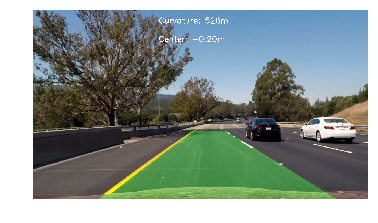

In [6]:
test_images = glob.glob('.\\test_images\\*.jpg')
for img_path in test_images:
    img = mpimg.imread(img_path)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    lf = LaneFinder()
    output = lf.process(undist)
    
    img_name = img_path.split('\\')[-1]
    plt.axis('off')
    plt.imshow(output)
    mpimg.imsave('.\\output_images\\{}'.format(img_name), output)

print('Done')

## Process Project Video

Run the pipeline on provided project video

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

if not os.path.exists("output_videos"):
    os.makedirs("output_videos")

In [8]:
lf = LaneFinder()
frame_idx = 1
def process_image(img):
    global frame_idx
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    output = lf.process(undist)
    #mpimg.imsave('.\\video_frames\\frame_{}.jpg'.format(frame_idx), undist)
    #mpimg.imsave('.\\output_images\\frame_{}.jpg'.format(frame_idx), output)
    frame_idx += 1
    return output


project_video_out = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video_1.mp4").subclip(20,28)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_out, audio=False)
del clip1

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:51<00:00,  7.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 2min 53s
